# How to detect breast cancer with a Support Vector Machine (SVM) and k-nearest neighbours clustering and compare results.

Load some packages 

In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import sklearn

from sklearn import preprocessing
from sklearn.model_selection import train_test_split # cross_validation is deprecated
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import classification_report, accuracy_score
from pandas.plotting import scatter_matrix


print('NumPy must be 1.14 to run this, it is {}'.format(np.__version__))
print('Python should be version 2.7 or higher, it is {}'.format(sys.version))

NumPy must be 1.14 to run this, it is 1.20.3
Python should be version 2.7 or higher, it is 3.9.5 (tags/v3.9.5:0a7dcbd, May  3 2021, 17:27:52) [MSC v.1928 64 bit (AMD64)]


Read in the dataset from thw UCI data repository.

This details a lot of information from cells, such as their size, clump thickness, shape etc. A pathologist would consider these to determine whether a cell had cancer. 

Specifically, we use the read_csv command from pd (pandas) package and supply a url of the dataset and some column names. Then we display the table.

In [2]:
# Load Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
names = ['id', 'clump_thickness', 'uniform_cell_size', 'uniform_cell_shape',
       'marginal_adhesion', 'single_epithelial_size', 'bare_nuclei',
       'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class']
df = pd.read_csv(url, names=names)

df.drop(['id'], 1, inplace = True) # We have removed the id field from the dataframe as we would not be running any models on it and we already know that each row represents a single cell.

display(df)

,clump_thickness,uniform_cell_size,uniform_cell_shape,marginal_adhesion,single_epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1,2
695,2,1,1,1,2,1,1,1,1,2
696,5,10,10,3,7,3,8,10,2,4
697,4,8,6,4,3,4,10,6,1,4


Get some summary statistics for each of our variables

In [3]:
df.describe()

,clump_thickness,uniform_cell_size,uniform_cell_shape,marginal_adhesion,single_epithelial_size,bland_chromatin,normal_nucleoli,mitoses,class
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


The dataset has some missing values. you can use .isnull() to return booleen true false and then tabulate that using .describe to say how many occurrences of true or false there are.

In [4]:
df.isnull().describe()

,clump_thickness,uniform_cell_size,uniform_cell_shape,marginal_adhesion,single_epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
count,699,699,699,699,699,699,699,699,699,699
unique,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False
freq,699,699,699,699,699,699,699,699,699,699


If you have missing data, you can replace it.

In [5]:
df.replace('?', -9999, inplace = True)

Class contains information on whether the tumour is benign (class = 2) or malignant (class = 4).

Next we plot a histogram of all variables to show the distrubition.

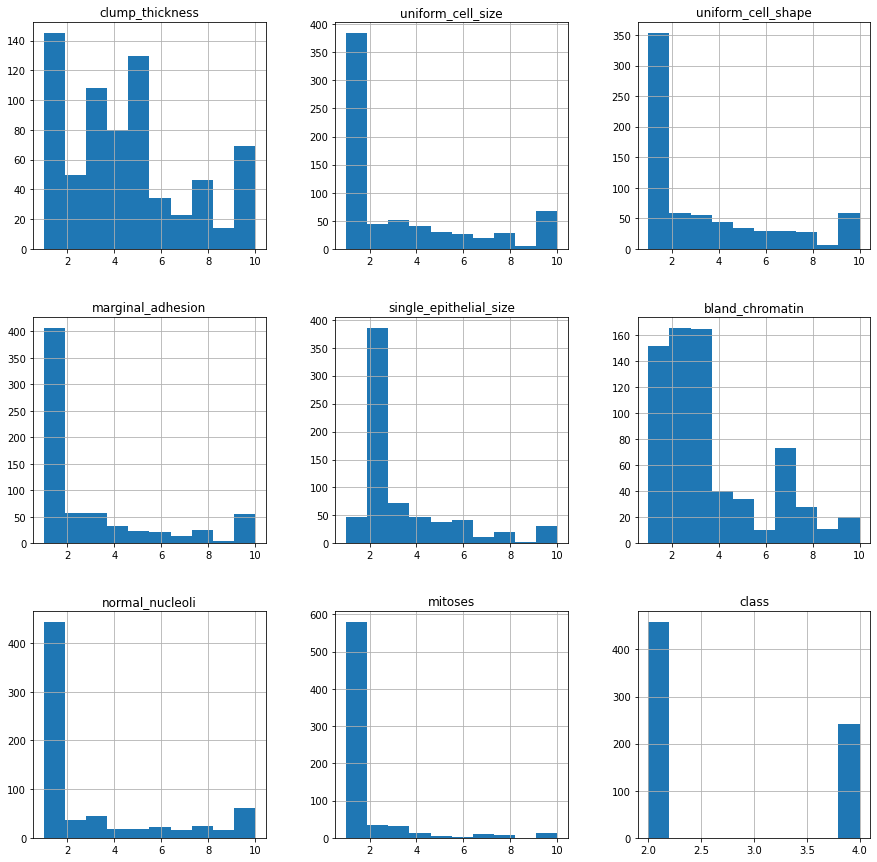

In [6]:
df.hist(figsize = (15,15))
plt.show() # by using plt.show() you render just the plot itself, because python will always display only the last command.

Look at the relationship between variables with a scatter matrix.

There looks like a pretty strong linear relationship between unifrorm cell shape and uniform cell size.

If you look at the cells representing comparisons with class (our outcome variable), it appears that there are a range of values for each of the items.

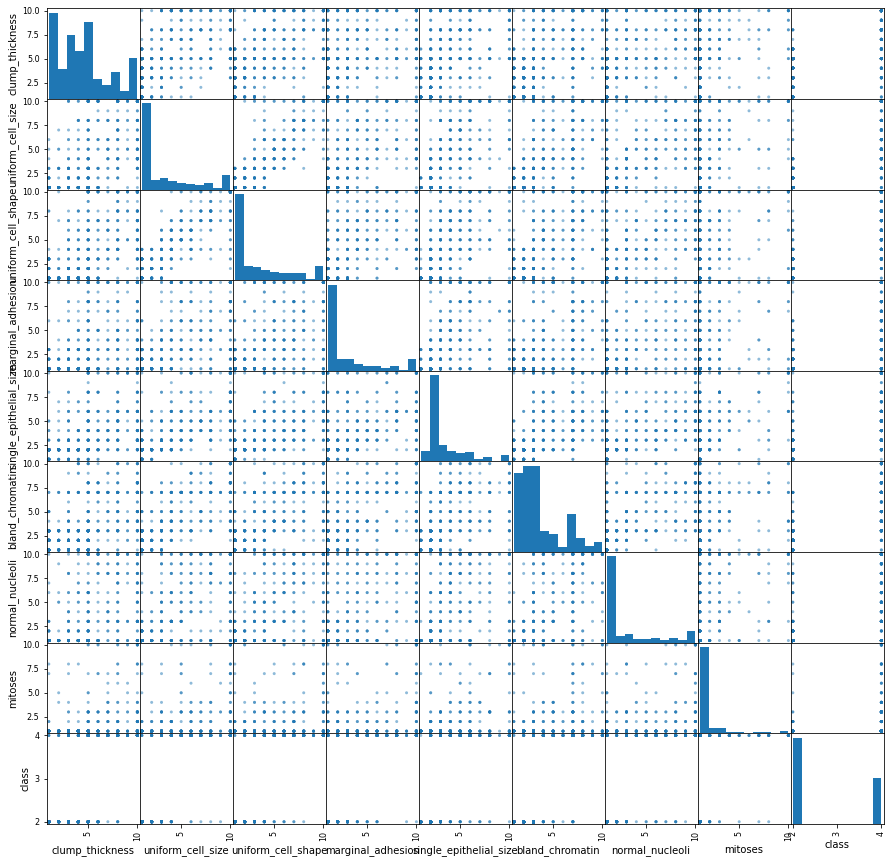

In [7]:
scatter_matrix(df, figsize = (15,15))
plt.show() # by using plt.show() you render just the plot itself, because python will always display only the last command.

### Models

Create training and testing datasets.

We need to keep some of the data back to validate the model, seeing how well it generalises to other data.

x data will contain all the potential explanatory variables (called features I think in this context)
y will contain the outcome data (called label in ML)

In [8]:
X_df = np.array(df.drop(['class'], 1)) # this will create a variable called X_df which is df except class
y_df = np.array(df['class']) # this is just the class field

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2) # split the dataset into four, two with features, two with labels (and choose 20% of the data for testing (validation))

Add a seed to make the data reproducible (this will change the results a little each time we run the model)

In [9]:
seed = 8
scoring = 'accuracy'

### Create training models

make an empty list then append

In [10]:
models = [] 
models.append(('KNN', KNeighborsClassifier(n_neighbors = 5))) # You can alter the number of neighbours
models.append(('SVM', SVC()))

results = [] # also create lists for results and names. We use this to print out the results
names = []

Evaluate each model in turn

In [11]:
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state = seed, shuffle = True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.967825 (0.023671)
SVM: 0.638539 (0.053601)


The KNN tries to cluster the data points into two groups, malignant and benign, whilst the SWM is looking for the optimal separating  hyperplane (??) that can separate the data points into malignant and benign cells

## Making predictions